# Natural Language Processing - Consumer Complaint in bank sector

## Research question: 

* How to develop an automatic text classification model that assigns customer complaints to the correct product categories based on their content?

Authors: Alam Jasia, Hubweber Michaela, Schumich Kathrin, Ye Florian

Dataset: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp

## State of the Art

1. What has been researched so far?
* Classifying customer complaints into predefined categories using advanced NLP techniques
* Various machine learning and deep learning techniques
* Word embeddings to capture semantic relationships in complaint texts
* Studies show high accuracy in categorizing consumer complaints based on text
* Some approaches also use dimensionality reduction for better data visualization and grouping

2. What are common approaches/models?
* Traditional Methods:  Naïve Bayes, Decision Trees, Support Vector Machines, Generalized Linear Model
* More advanced approaches: LSTM, GRU, and CNN
* Word Embeddings (Word2Vec, BERT)
* Transformer Models (DistilBERT and FinBERT)
* Sentiment analysis to identify trends

Similar work and differences from ours? Existing research has explored the categorization of customer complaints, particularly through the use of NLP techniques to analyze text. However, our work **placeholder**

**References**
* Vinayak, V., & C., J. (2023). Consumer Complaints Classification using Deep Learning & Word Embedding Models. 2023 14th International Conference on Computing Communication and Networking Technologies (ICCCNT), 1-5.
* Kohler, M., Sondermann, L., Forero, L., & Pacheco, M.A. (2018). Classifying and Grouping Narratives with Convolutional Neural Networks, PCA and t-SNE. International Conference on Health Information Science.
* Research, M., & Rafiee, D.M. (2020). Analysis of Customer Complaint Data of Consumer Financial Protection Bureau Using Different Text Classification Methods.
* Correa, N., & Correa, A. (2022). Neural Text Classification for Digital Transformation in the Financial Regulatory Domain. 2022 IEEE ANDESCON, 1-6.



## CODE

### 0 Code Setup & Data Loading

##### All necessary packages 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from IPython.display import display
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from scipy import stats
from textblob import TextBlob
from spacy.cli import download
from sklearn.preprocessing import LabelEncoder  # For encoding labels

import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from sentence_transformers import SentenceTransformer
import zipfile

from gensim.models import Word2Vec
from narrative_to_vec import tokenize_column, add_column_average_genre_vector

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
## Download the language model
try:
    # Try to load the language model
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model loaded successfully.")
except OSError:
    # If the model is not available, download it using spacy.cli.download
    print("Model not found. Downloading...")
    download("en_core_web_sm")
    
    # After downloading, try loading again
    spacy_nlp = spacy.load("en_core_web_sm")
    print("Model downloaded and loaded successfully.")

Model loaded successfully.


In [3]:
data_path = os.path.join("data", "raw.zip")
print(data_path)

data/raw.zip


## 1 Pre-Processing

* Cleaning
* Stemming
* Lemmatization
* Tokenization

Reading in the data and removing the index column.

In [4]:
# Load data
data = pd.read_csv(data_path)
# Delete first row (index)
data = data.drop(data.columns[0], axis=1)

data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


Überprüfung auf fehlende Werte. Da nur 10 von 160k der Narratives fehlen, werden sie einfach entfernt.

In [5]:
# Check the number of rows
print("Number of rows: ", data.shape[0])
# Check for missing values
print("Number of missing values: ", data.isnull().sum().sum())
data = data.dropna() #drop missing values
# Check number of rows after dropping missing values
print("Number of rows after dropping missing values ", data.shape[0])

Number of rows:  162421
Number of missing values:  10
Number of rows after dropping missing values  162411


Check whether HTML tags, punctuation and numbers are present and whether content is written in Upper Case. Since this is not the case, no transformations are carried out in this sense.

In [6]:
print("Number of rows with html tags:", data['narrative'].str.contains('<.*?>', regex=True).sum())
print("Number of rows with punctuation:", data['narrative'].str.contains('[^\w\s]', regex=True).sum())
print("Number of rows with numbers:", data['narrative'].str.contains('\d', regex=True).sum())
print("Number of rows with uppercase:", data['narrative'].str.contains('[A-Z]', regex=True).sum())

Number of rows with html tags: 0
Number of rows with punctuation: 0
Number of rows with numbers: 0
Number of rows with uppercase: 0


In [7]:
# Calculate length of narrative (before preprocessing)
data['narrative_len'] = data['narrative'].apply(lambda text: len(text.split()))

Creating a new column that removes stop words from narrative. Remove the rows with less than 4 words in the new column as they are hardly meaningful and represent only a fraction of the total data

In [8]:
# Create a columns for the cleaned narrative
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

data['narrative_prep'] = data['narrative'].apply(lambda text: remove_stopwords(text))

In [9]:
# Show number of that are empty after removing stop words
print("Number of rows with empty narratives after removing stop words:", data[data['narrative_prep'] == ''].shape[0])
# Show number of rows with narratives that have less than 4 words
print("Number of rows with narratives that have less than 4 words:", data[data['narrative_prep'].str.split().apply(len) < 4].shape[0])

# Remove rows with narratives that have less than 4 words
data = data[data['narrative_prep'].str.split().apply(len) >= 4]

# Show number of rows after removing rows
print("Number of rows after removing rows", data.shape[0])

Number of rows with empty narratives after removing stop words: 7
Number of rows with narratives that have less than 4 words: 1756
Number of rows after removing rows 160655


In [10]:
# Calculate the length of narrative
data['narrative_prep_len'] = data['narrative_prep'].apply(lambda text: len(text.split()))

In [11]:
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len
0,credit_card,purchase order day shipping amount receive pro...,230,purchase order day shipping receive product we...,203
1,credit_card,forwarded message date tue subject please inve...,132,forwarded message date tue subject investigate...,121
2,retail_banking,forwarded message cc sent friday pdt subject f...,173,forwarded message cc sent friday pdt subject f...,147
3,credit_reporting,payment history missing credit report speciali...,131,payment history missing credit report speciali...,110
4,credit_reporting,payment history missing credit report made mis...,123,payment history missing credit report mistake ...,102


## 2 Explorative Data Analysis

In [12]:
print(data.dtypes)


product               object
narrative             object
narrative_len          int64
narrative_prep        object
narrative_prep_len     int64
dtype: object


In [13]:
# Count the occurrences of each product type
product_counts = data['product'].value_counts()
product_counts

product
credit_reporting       89748
debt_collection        22987
mortgages_and_loans    18955
credit_card            15530
retail_banking         13435
Name: count, dtype: int64

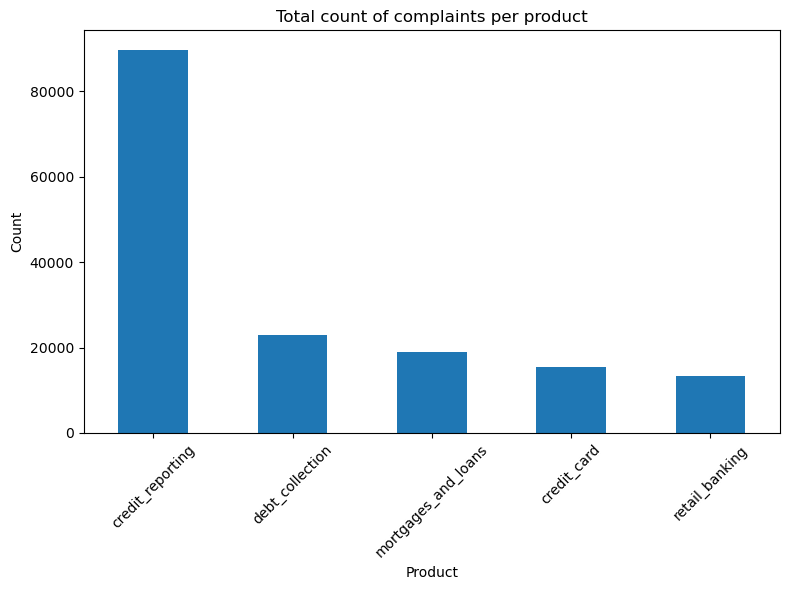

In [14]:
# Create the plot
plt.figure(figsize=(8, 6))
product_counts.plot(kind='bar')
plt.title('Total count of complaints per product')
plt.xlabel('Product')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjusts layout to prevent label cutoff
plt.show()

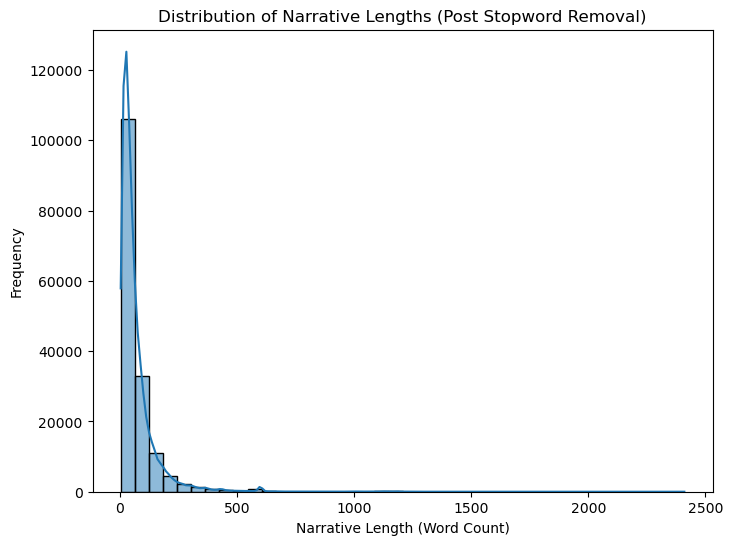

In [15]:
# Distribution of Narrative Lengths (after stopword removal)
plt.figure(figsize=(8, 6))
sns.histplot(data['narrative_prep_len'], bins=40, kde=True)
plt.title('Distribution of Narrative Lengths (Post Stopword Removal)')
plt.xlabel('Narrative Length (Word Count)')
plt.ylabel('Frequency')
plt.show()

In [16]:
# 1. Overall Summary Statistics for length_narrative_preprocessed
overall_summary = data['narrative_prep_len'].describe()

# Display overall summary statistics
print("Overall Summary Statistics - length_narrative_preprocessed:")
display(overall_summary)

Overall Summary Statistics - length_narrative_preprocessed:


count    160655.000000
mean         71.113342
std          97.334293
min           4.000000
25%          24.000000
50%          44.000000
75%          83.000000
max        2410.000000
Name: narrative_prep_len, dtype: float64

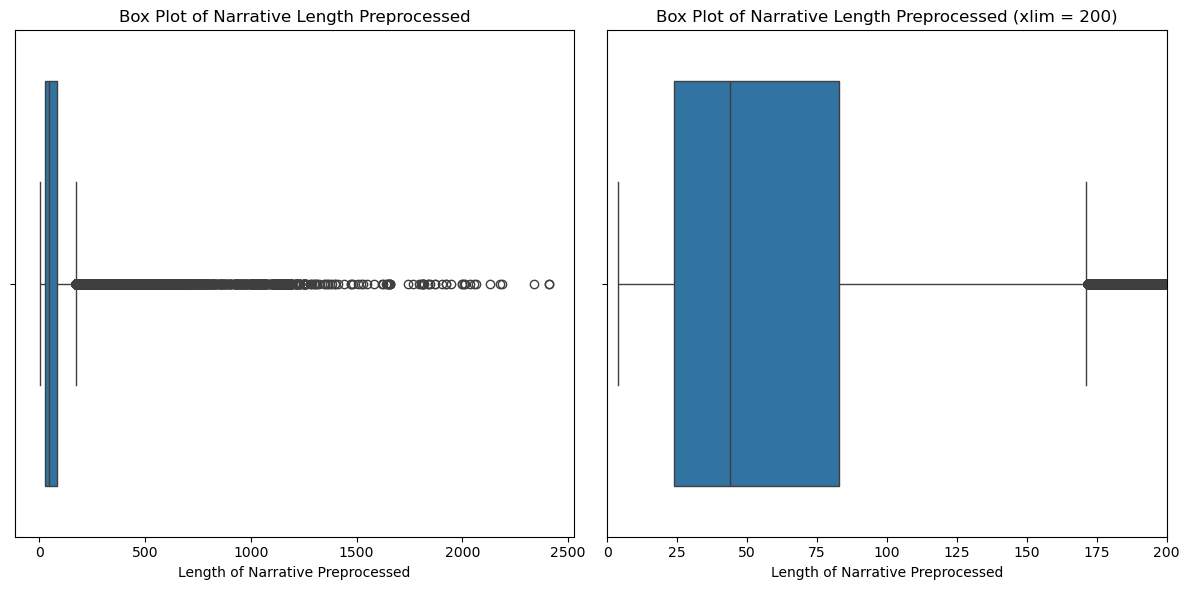

In [17]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot of overall narrative length on the first subplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[0])  # Create the boxplot
axes[0].set_title('Box Plot of Narrative Length Preprocessed')
axes[0].set_xlabel('Length of Narrative Preprocessed')

# Boxplot of overall narrative length (with xlim=200) on the second subplot
sns.boxplot(x=data['narrative_prep_len'], ax=axes[1])  # Create the boxplot
axes[1].set_xlim(0, 200)  # Set the x-axis limit
axes[1].set_title('Box Plot of Narrative Length Preprocessed (xlim = 200)')
axes[1].set_xlabel('Length of Narrative Preprocessed')

plt.tight_layout()
plt.show()

In [18]:
# 2. Group-wise Summary Statistics for each product
grouped_summary = data.groupby('product')['narrative_prep_len'].describe()

# Display group-wise summary statistics
print("\nGroup-wise Summary Statistics by Product:")
display(grouped_summary)


Group-wise Summary Statistics by Product:


,count,mean,std,min,25%,50%,75%,max
product,,,,,,,,
credit_card,15530.0,84.479395,85.383704,4.0,34.0,61.0,106.0,2038.0
credit_reporting,89748.0,61.205943,94.411572,4.0,21.0,36.0,65.0,2410.0
debt_collection,22987.0,69.811241,99.643645,4.0,23.0,44.0,83.0,2064.0
mortgages_and_loans,18955.0,101.391295,112.176236,4.0,41.0,72.0,121.0,2341.0
retail_banking,13435.0,81.355787,91.190146,4.0,28.0,57.0,101.0,1581.0


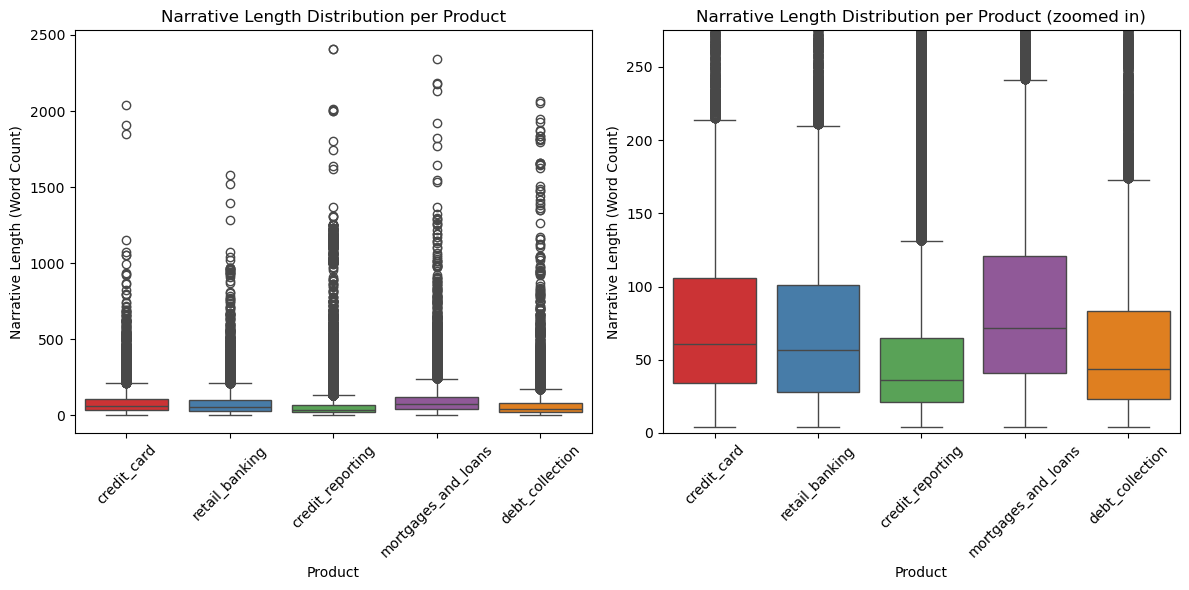

In [19]:
# Boxplot of Narrative Length per Product
def boxplot_narrative_length(data, title, ylim: int = None, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x='product', y='narrative_prep_len', data=data, palette='Set1', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Product')
    ax.set_ylabel('Narrative Length (Word Count)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ylim is not None:
        ax.set_ylim(0, ylim)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first boxplot
boxplot_narrative_length(data, title='Narrative Length Distribution per Product', ax=axes[0])

# Plot the second boxplot with a y-limit of 275
boxplot_narrative_length(data, title='Narrative Length Distribution per Product (zoomed in)', ylim=275, ax=axes[1])

plt.tight_layout()
plt.show()

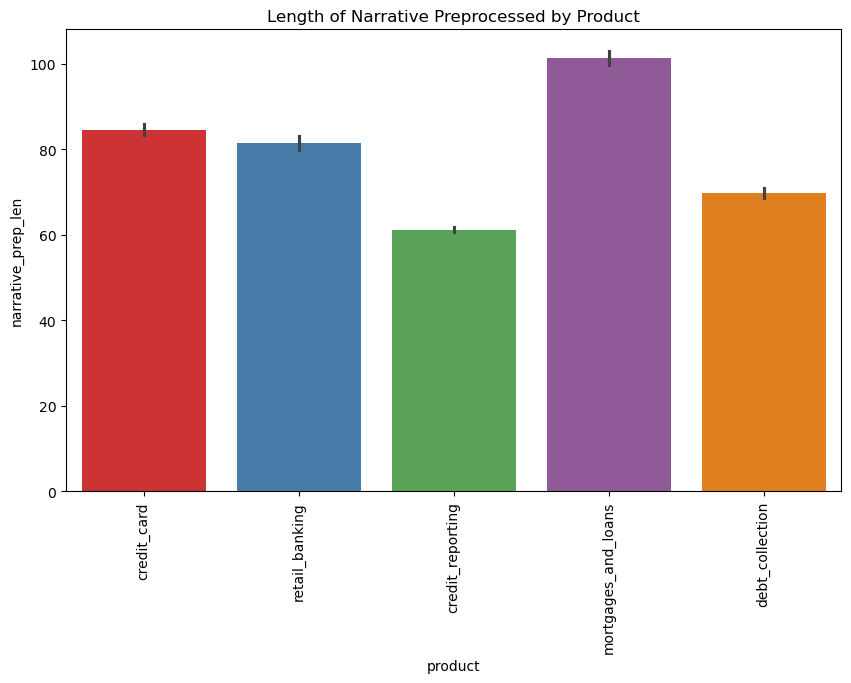

In [20]:
# Barplot of Narrative length per Product
plt.figure(figsize=(10,6))
sns.barplot(data=data, x='product', y='narrative_prep_len', palette ='Set1')
plt.xticks(rotation=90)
plt.title('Length of Narrative Preprocessed by Product')
plt.show()

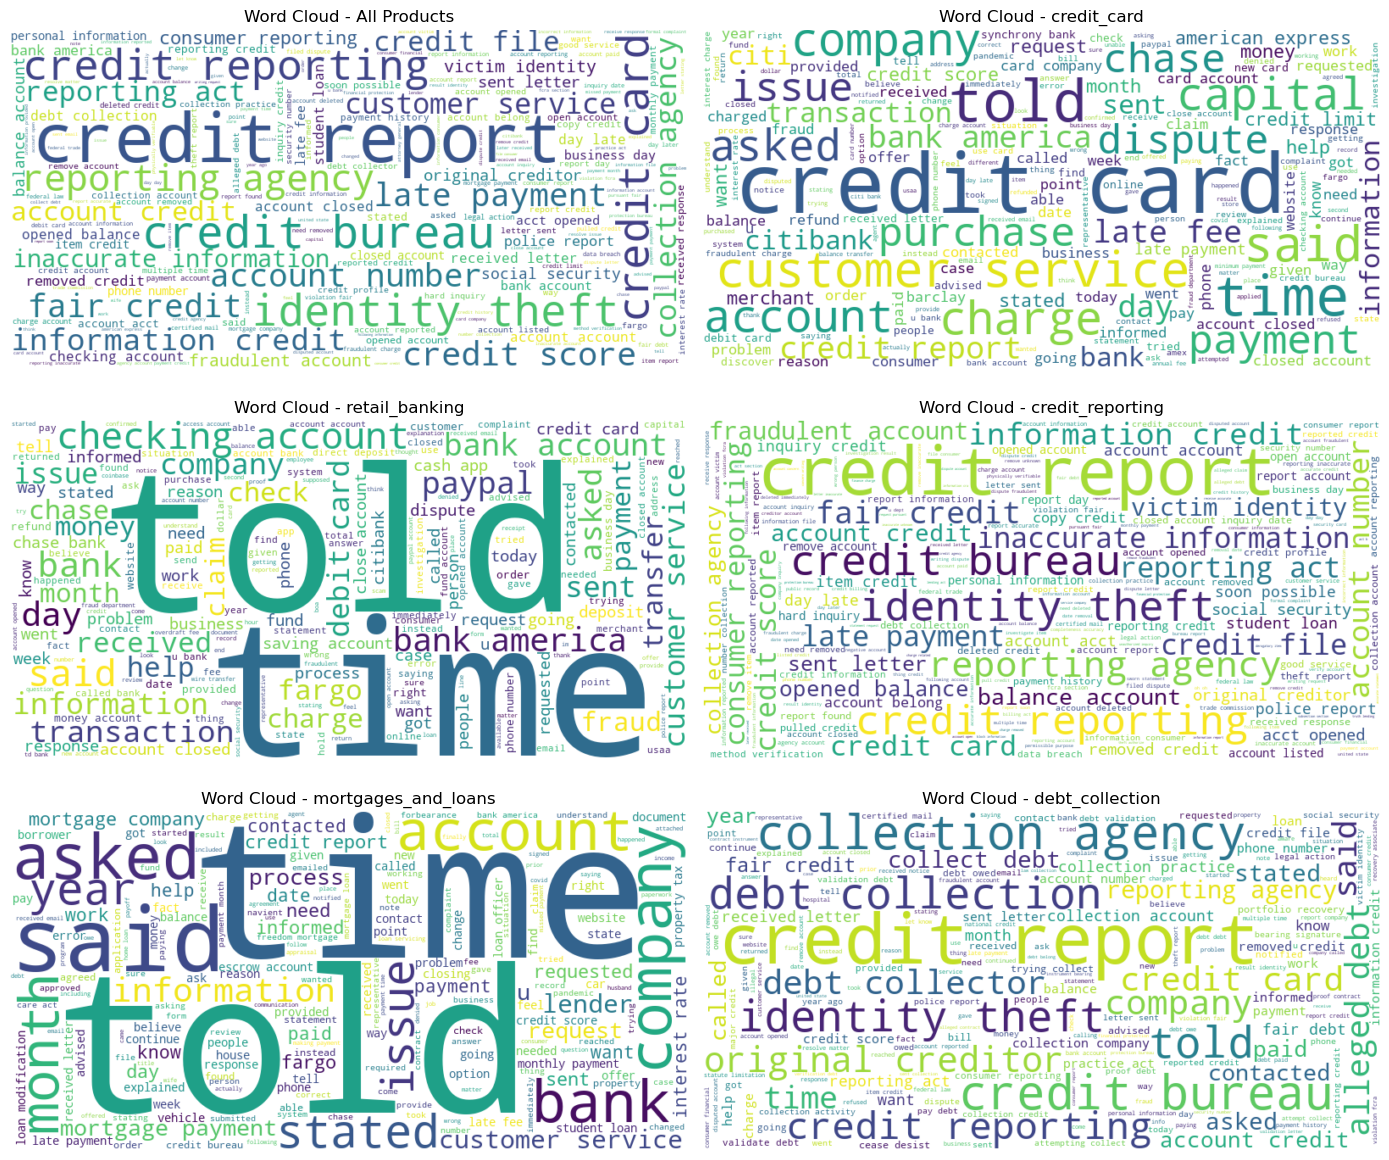

In [21]:
# Word clouds for the entire dataset and five for each product category
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Generate word cloud for the whole dataset
all_words = ' '.join(data['narrative_prep'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
axes[0, 0].imshow(wordcloud, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Word Cloud - All Products')

# Generate word clouds for each product category
product_categories = data['product'].unique()

for i, product in enumerate(product_categories):
    product_words = ' '.join(data[data['product'] == product]['narrative_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_words)
    row, col = divmod(i + 1, 2)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Word Cloud - {product}')

# Remove any unused subplots
for j in range(len(product_categories) + 1, 6):
    row, col = divmod(j, 3)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

##### Conclusion EDA:

* The classes are very similar and the words that appear in the text regarding the categories match a lot. Therefore the dataset seems to be more challenging than expected at the beginning. 
* Package TextBlob not suited for the purpose of this project, therefore redo setimental analysis. 
* The size of the dataset can also be a challenge thus one can take a subset of the dataset due to technical and time limit.

## 3 Feature Engineering

While exploring the data, we found that the data is imbalanced. (see EDA)
As we also wanted to work with a smaller dataset, we decided to undersample the data based on the product category with the least amount of complaints. 

In [22]:
# create small, already balanced data set: 
min_count = data['product'].value_counts().min()  # get the smalles product category count
print(min_count)
# sample min_count samples from each category
small_df = data.groupby('product').apply(lambda x: x.sample(min_count, random_state=99)).reset_index(drop=True)
print(small_df['product'].value_counts())
# save to zip file
small_df.to_csv("data/small.zip", index=False, compression="zip")
data = small_df


13435
product
credit_card            13435
credit_reporting       13435
debt_collection        13435
mortgages_and_loans    13435
retail_banking         13435
Name: count, dtype: int64


In [23]:
# Lemmatize text 
### MAY TAKE A WHILE TO RUN ###
### Depending on system, changing batch size could speed up the process (I think :) )
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in spacy_nlp.pipe(data["narrative_prep"], batch_size=1000, n_process=-1): # runs in parallel (cpu)
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
data["text_lemma"] = lemma_text_list

In [24]:
data['word_count'] = data['narrative'].apply(lambda x: len(x.split()))
data['char_count'] = data['narrative'].apply(lambda x: len(x))
data['sentence_count'] = data['narrative'].apply(lambda x: len(x.split('.')))

data[['narrative', 'word_count', 'char_count', 'sentence_count']].head()

,narrative,word_count,char_count,sentence_count
0,used third party company book vacation package...,64,485,1
1,company u bank reliacard issue account locked ...,66,421,1
2,victim identity fraud personal financial infor...,91,696,1
3,browsing online site invited apply credit card...,70,496,1
4,made payment credit card balance resulting cre...,20,143,1


 ### TF-IDF
Extracting key text features using TF-IDF

In [25]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data['narrative_prep'])

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
display(tfidf_df.head())

,account,bank,called,card,company,credit,day,debt,information,letter,loan,money,month,payment,received,report,said,sent,time,told
0,0.000000,0.371500,0.000000,0.000000,0.904632,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.208876,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.228969,0.515305,0.000000,0.000000,0.167308,0.000000,0.168152,0.0,0.172351,0.0,0.0,0.193154,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.747498,0.000000
2,0.117642,0.706022,0.177973,0.369959,0.000000,0.377729,0.000000,0.0,0.354209,0.0,0.0,0.000000,0.0,0.000000,0.0,0.165549,0.0,0.000000,0.153623,0.000000
3,0.000000,0.232403,0.000000,0.852465,0.000000,0.414461,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.217977,0.0,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.598907,0.000000,0.407657,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.549107,0.0,0.000000,0.0,0.298447,0.000000,0.290754


In [26]:
tfidf_df

,account,bank,called,card,company,credit,day,debt,information,letter,loan,money,month,payment,received,report,said,sent,time,told
0,0.000000,0.371500,0.000000,0.000000,0.904632,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.208876,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.228969,0.515305,0.000000,0.000000,0.167308,0.000000,0.168152,0.0,0.172351,0.0,0.0,0.193154,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.747498,0.000000
2,0.117642,0.706022,0.177973,0.369959,0.000000,0.377729,0.000000,0.0,0.354209,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.165549,0.000000,0.000000,0.153623,0.000000
3,0.000000,0.232403,0.000000,0.852465,0.000000,0.414461,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.217977,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.598907,0.000000,0.407657,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.549107,0.0000,0.000000,0.000000,0.298447,0.000000,0.290754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67170,0.441271,0.000000,0.667573,0.000000,0.214958,0.000000,0.432086,0.0,0.000000,0.0,0.0,0.248165,0.0,0.000000,0.0000,0.000000,0.255216,0.000000,0.000000,0.000000
67171,0.000000,0.368541,0.743213,0.000000,0.000000,0.000000,0.360783,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.426201,0.000000,0.000000,0.000000
67172,0.504037,0.000000,0.000000,0.000000,0.000000,0.000000,0.370160,0.0,0.000000,0.0,0.0,0.425197,0.0,0.000000,0.3523,0.000000,0.000000,0.394942,0.000000,0.384761
67173,0.833373,0.312591,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.326498,0.000000,0.318081


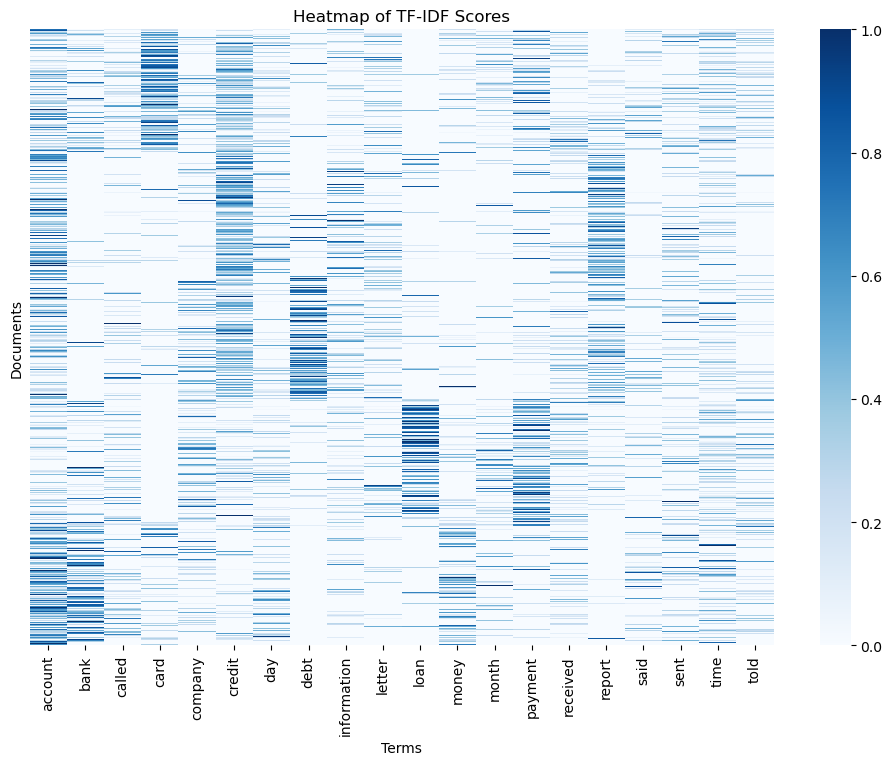

In [27]:
# Plot a heatmap of the TF-IDF matrix
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_df, cmap='Blues', yticklabels=False)
plt.title('Heatmap of TF-IDF Scores')
plt.xlabel('Terms')
plt.ylabel('Documents')
plt.show()

The heatmap shows how the TF-IDF scores are distributed across different narratives (documents).

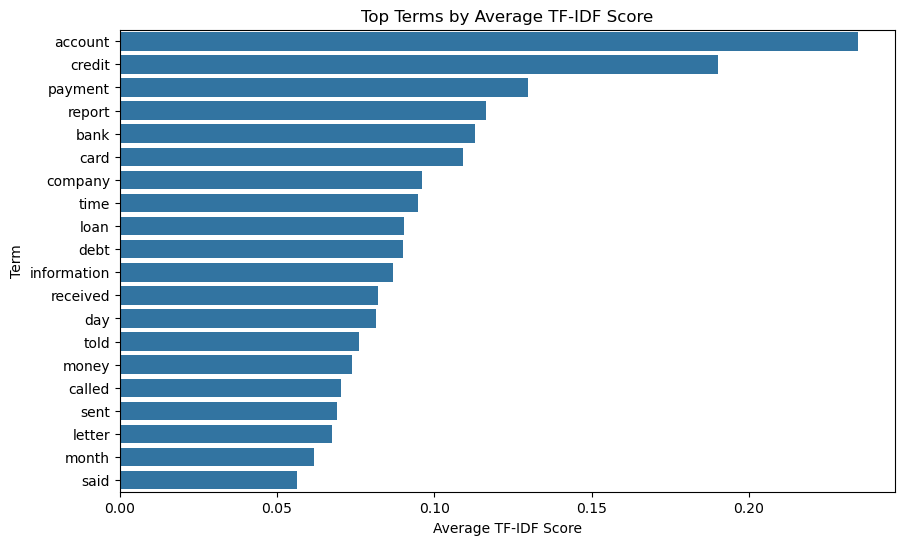

In [28]:
# Get the average TF-IDF score for each term across all documents
tfidf_mean = tfidf_df.mean().sort_values(ascending=False)

# Plot the top terms by average TF-IDF score
plt.figure(figsize=(10, 6))
sns.barplot(x=tfidf_mean.values, y=tfidf_mean.index)
plt.title('Top Terms by Average TF-IDF Score')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

#### Top words by TF-IDF score by products:

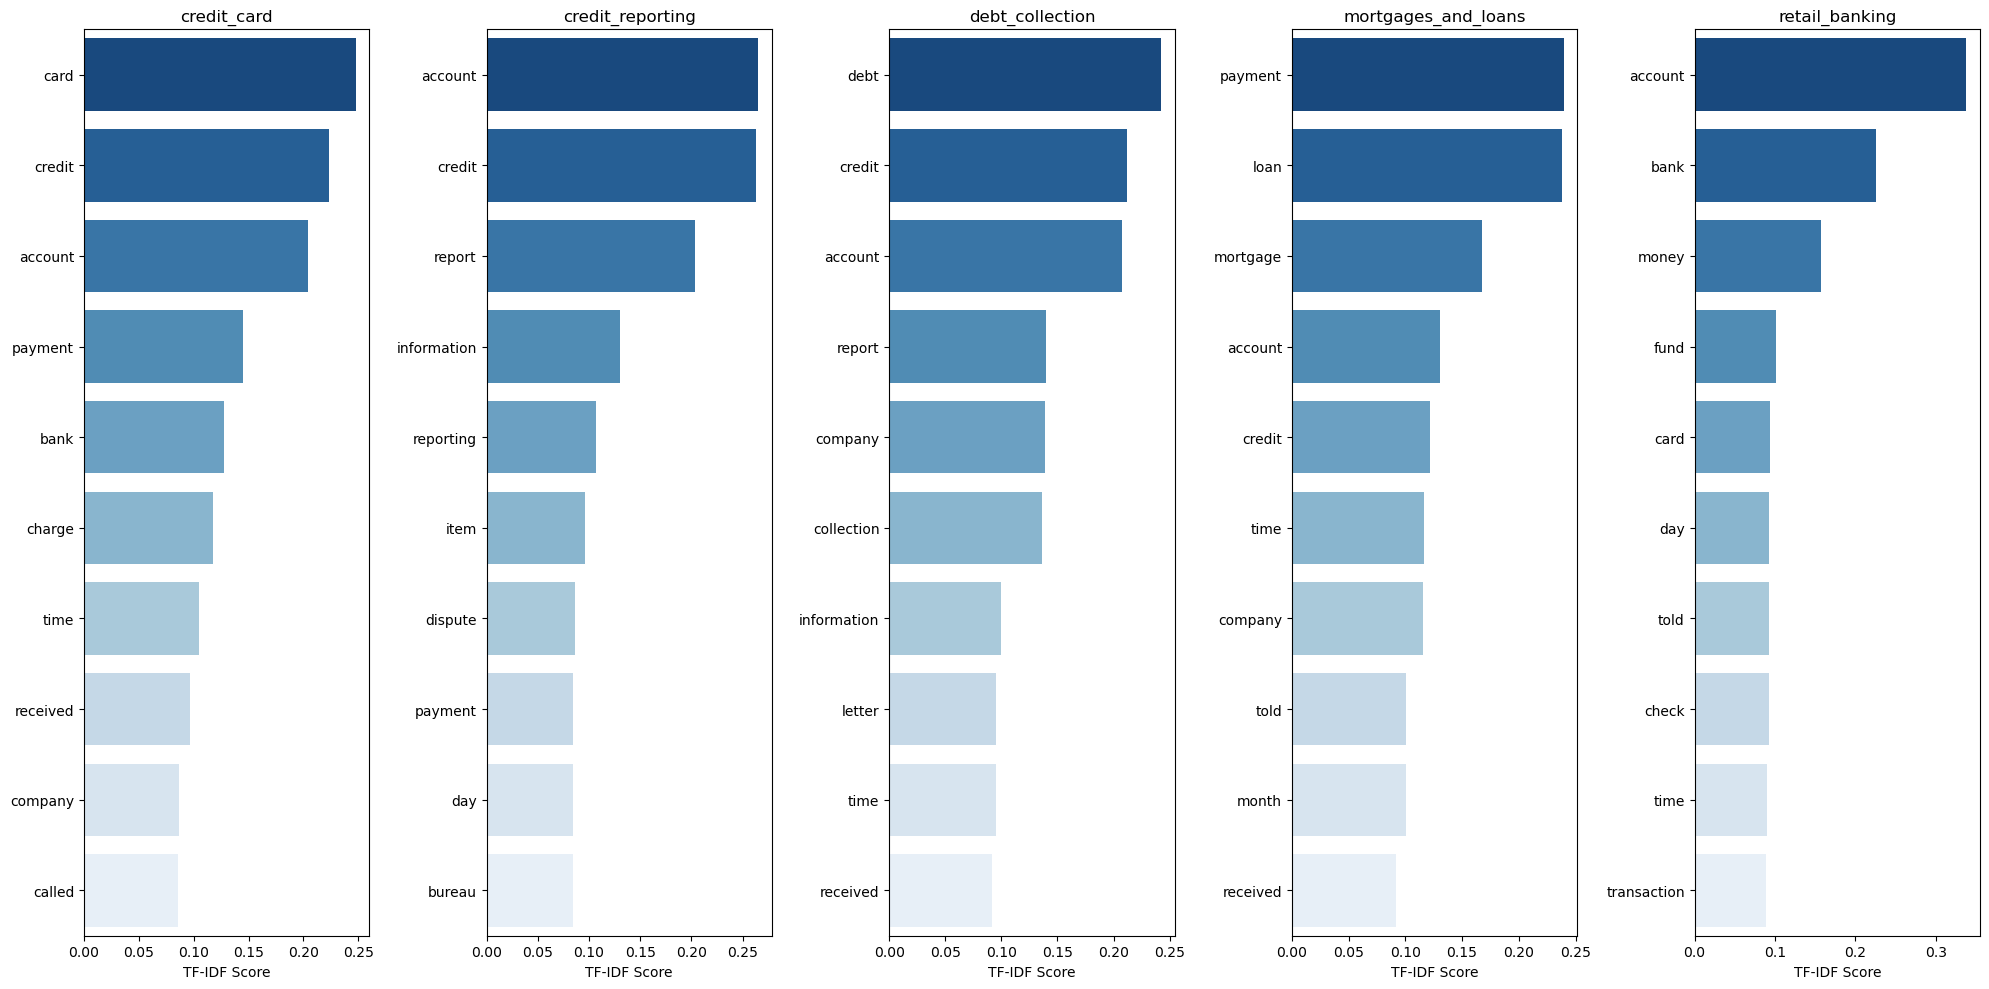

In [29]:
products = data['product'].unique()

# Initialize a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=20)

# Create a figure with a 2x5 grid of subplots (adjust the number of rows and columns based on your product count)
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.flatten()  # Flatten to easily index subplots

# Iterate through each product and its corresponding subplot
for i, product in enumerate(products):
    # Filter the data for the current product
    product_data = data[data['product'] == product]
    
    # Apply TF-IDF on the 'narrative_prep' column for the current product
    tfidf_matrix = tfidf.fit_transform(product_data['narrative_prep'])
    
    # Create a DataFrame with the TF-IDF scores for each term
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    
    # Compute the average TF-IDF score for each term
    tfidf_mean = tfidf_df.mean().sort_values(ascending=False)
    
    # Take the top 10 terms with the highest TF-IDF scores
    top_words = tfidf_mean.head(10)
    
    # Plot the top words for this product in its corresponding subplot
    sns.barplot(x=top_words.values, y=top_words.index, ax=axes[i], palette = 'Blues_r')
    axes[i].set_title(f'{product}')
    axes[i].set_xlabel('TF-IDF Score')
    axes[i].set_ylabel('')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#### Sentiment-Analyse: 
Conducting sentiment analysis to find out whether the text is negative, neutral or positive.

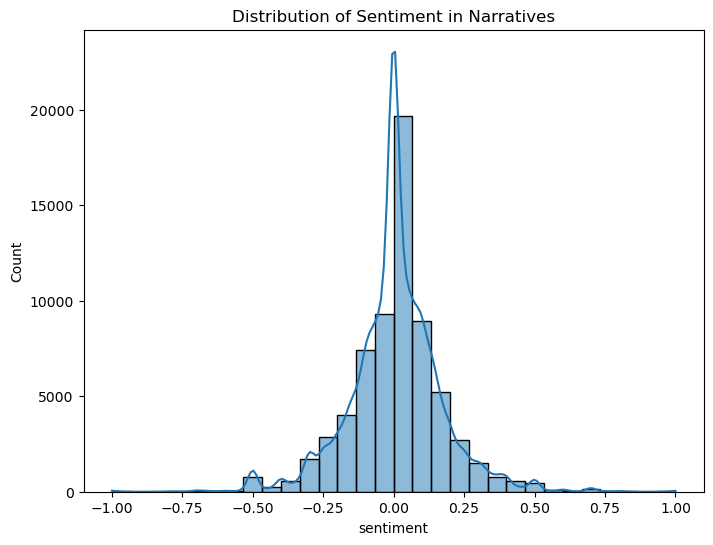

In [30]:
data['sentiment'] = data['narrative_prep'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.figure(figsize=(8,6))
sns.histplot(data['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment in Narratives')
plt.show()

The calculated sentiment score ranges from -1 (negative), to 0 (neutral) and 1 (positive).

#### Sentiment-Analyse by products:

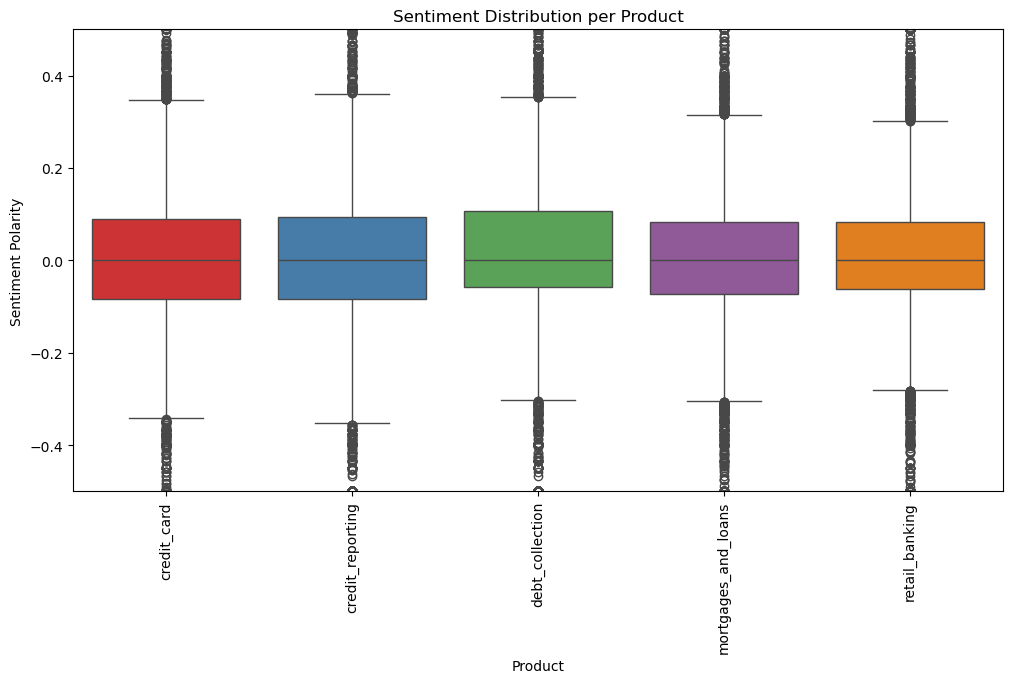

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='product', y='sentiment', palette='Set1')
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5)
plt.title('Sentiment Distribution per Product')
plt.ylabel('Sentiment Polarity')
plt.xlabel('Product')
plt.show()

In [32]:
data.to_csv('data/small_data_eda.zip', index=False, compression='zip')

### Label Encoding

In [33]:
from sklearn.preprocessing import LabelEncoder  # For encoding labels
 #Step 3: Encode the target variable (Product Categories)
le = LabelEncoder()
y = le.fit_transform(data['product'])  # Transform product categories into numerical labels
y

array([0, 0, 0, ..., 4, 4, 4])

## 4 Testing different embedding techniques

***Goal: Try out different embeddings to see, how (or if) the product categories can be clustered by cosine similarity.***

In [34]:
# Data Loading
data_path = os.path.join("data", "small_data_eda.zip")
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len,text_lemma,word_count,char_count,sentence_count,sentiment
0,credit_card,used third party company book vacation package...,64,party company book vacation package notified c...,53,party company book vacation package notify com...,64,485,1,-0.138095
1,credit_card,company u bank reliacard issue account locked ...,66,company u bank reliacard issue account locked ...,58,company u bank reliacard issue account locked ...,66,421,1,-0.083333
2,credit_card,victim identity fraud personal financial infor...,91,victim identity fraud personal financial infor...,83,victim identity fraud personal financial infor...,91,696,1,-0.002679
3,credit_card,browsing online site invited apply credit card...,70,browsing online site invited apply credit card...,64,browse online site invite apply credit card si...,70,496,1,-0.243056
4,credit_card,made payment credit card balance resulting cre...,20,payment credit card balance resulting credit b...,18,payment credit card balance result credit bala...,20,143,1,0.000000


In [35]:
# write a function to get and plot cosine similiraty by product category
def plot_cosine_similarity(embeddings, name):
    cosine_sim = cosine_similarity(embeddings)
    # plot the cosine similarity matrix
    sns.heatmap(cosine_sim, annot=True, cmap='coolwarm',
                xticklabels=embeddings.index,
                yticklabels=embeddings.index
                ).set_title("Cosine Similarity Matrix for " + name)  

#### 4.1 TFIDF on lemmatized text
* Updated TFIDF (inclusive Feedback Presentation 1)

In [36]:
# Create a TF-IDF vectorizer and fit it on the complaints
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['text_lemma'])
# Convert to a dataframe for easier manipulation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [37]:
# Add the categories back to the dataframe
tfidf_df['product'] = data['product'].values
# Group by category and calculate the average TF-IDF values for each
category_embeddings = tfidf_df.groupby('product').mean()

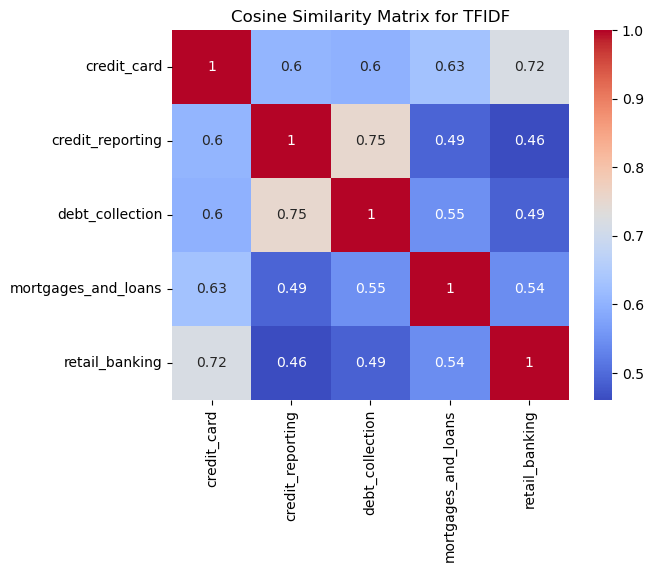

In [38]:
plot_cosine_similarity(category_embeddings, "TFIDF")

#### 4.2 GLOVE on lemmatized text

The used model glove.6B.100d.txt is to large to push to github, but can be downloaded from https://nlp.stanford.edu/projects/glove/ and should be placed in the data folder.

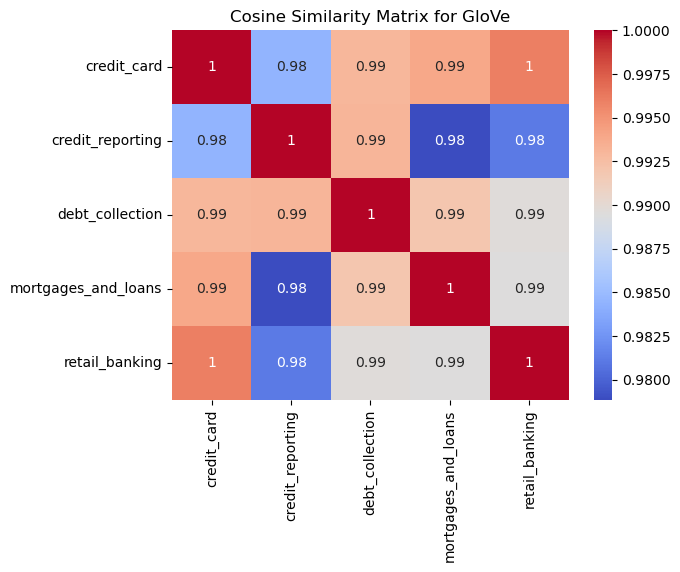

In [39]:
# Load the model
def load_glove_model():
    zip_path = os.path.join("data", "glove.6B.100d.zip")
    glove_file = os.path.join("data", "glove.6B.100d.txt")

    #unzip the file if not already unzipped
    if not os.path.exists(glove_file):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("data")
        
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

# Get the average GloVe embedding for a complaint
def get_average_embedding(text, glove_model):
    words = text.split()
    embeddings = []
    for word in words:
        if word in glove_model:
            embeddings.append(glove_model[word])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

# Load Model and get embeddings
glove_model = load_glove_model()
#get_embedding(data["text_lemma"][0], glove_model)
glove_df = data['text_lemma'].apply(lambda x: get_average_embedding(x, glove_model)).to_frame()
glove_df['product'] = data['product'].values
glove_df = glove_df.groupby('product')['text_lemma'].apply(np.mean)
glove_df = pd.DataFrame(glove_df.tolist(), index=glove_df.index)
glove_df
plot_cosine_similarity(glove_df, "GloVe")


#### 4.3 Sentence transformers on unlemmatized text:

In [40]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [41]:
sbert = model.encode(data["narrative_prep"])

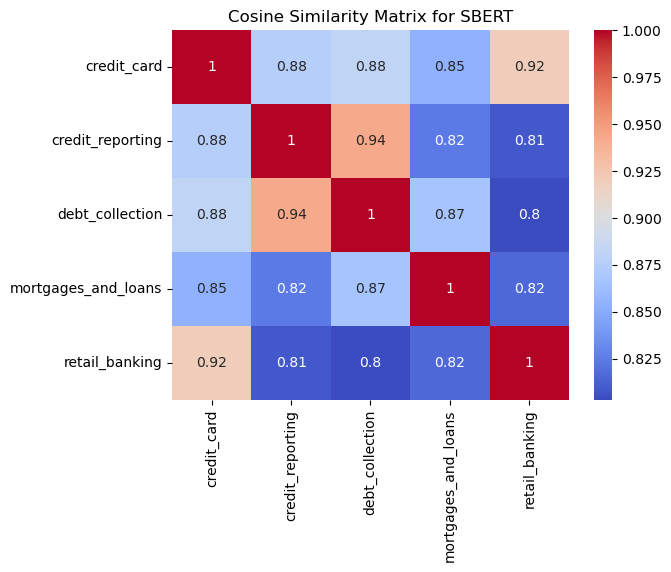

In [42]:
sbert_df = pd.DataFrame(sbert)
sbert_df['product'] = data['product'].values
sbert_df = sbert_df.groupby('product').mean()
plot_cosine_similarity(sbert_df, "SBERT")

#### 4.4 Word-to-Vec

In [43]:
from narrative_to_vec import tokenize_column, add_column_average_genre_vector, train_word2vec_model, store_data

In [44]:
col_name = "narrative_tokenized"


# Tokenize the column
data_w2v = tokenize_column(data, "narrative_prep", col_name)

# Train a Word2Vec model on the genres
train_word2vec_model(data, col_name=col_name)

# Add a new column with the average genre vector
data_w2v = add_column_average_genre_vector(data, 
                                        model_path="narrative_word2vec.model", 
                                        col_name=col_name)

# Store the data as a new CSV file
store_data(data_w2v, "data/data_narrative_vector.csv")

print("Done!")


Done!


In [45]:
data_w2v_df = data_w2v.groupby('product')['narrative_tokenized_vector'].apply(np.mean)
data_w2v_df = pd.DataFrame(data_w2v_df.tolist(), index=glove_df.index)
data_w2v_df

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
product,,,,,,,,,,,,,,,,,,,,,
credit_card,-0.213963,0.646378,0.219971,-0.239569,-0.135342,0.304538,0.203522,-0.534475,-0.267315,-0.179778,...,-0.409634,-0.252111,-0.095061,0.362694,-0.412114,-0.235397,0.324009,-0.316121,-0.354968,0.747950
credit_reporting,-0.670830,0.496453,0.254874,-0.095270,-0.401735,0.375343,0.330623,-0.472605,-0.184228,-0.041776,...,-0.184599,-0.419802,-0.030337,0.011443,-0.097224,-0.320324,-0.178526,-0.172689,-0.312093,0.455874
debt_collection,-0.363476,0.627621,0.103913,-0.234187,-0.220602,0.447347,0.346832,-0.190535,-0.410476,-0.096990,...,-0.267622,-0.265457,-0.087355,0.042924,-0.132580,-0.321320,-0.040890,-0.069201,-0.330360,0.484187
mortgages_and_loans,0.019939,0.598702,-0.011460,-0.339100,-0.160091,0.180935,0.244260,-0.611647,-0.300564,-0.245913,...,-0.600685,-0.041759,-0.163773,0.289226,-0.279315,-0.092013,0.117404,-0.265279,-0.194489,0.614635
retail_banking,-0.252066,0.736160,0.208015,-0.023052,-0.033837,0.144242,0.076349,-0.557985,-0.222240,-0.171892,...,-0.511797,-0.142808,-0.329695,0.227109,-0.497743,-0.067029,0.417689,-0.426137,-0.515839,0.780468


In [46]:
similarity_matrix = cosine_similarity(data_w2v_df)

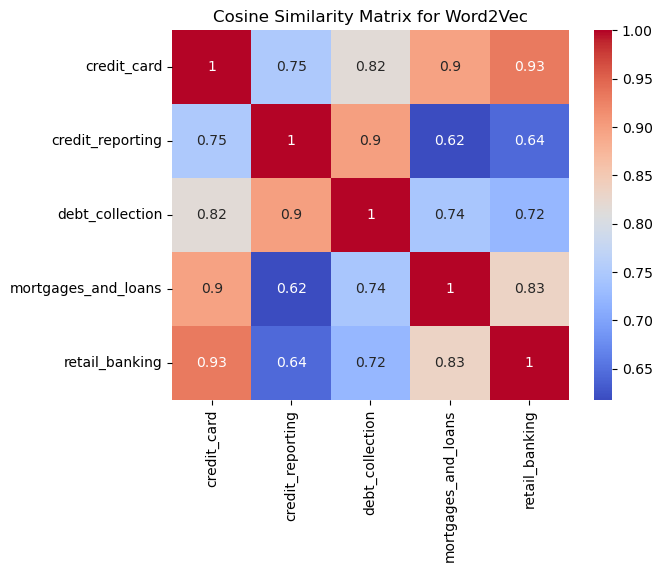

In [47]:
plot_cosine_similarity(data_w2v_df, "Word2Vec")

## Model evaluation

In [48]:
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.linear_model import LogisticRegression  # For training the model
from sklearn.metrics import accuracy_score, classification_report  # For evaluating the model
import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

In [49]:
data_path = os.path.join("data", "small_data_eda.zip")
# Load data
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len,text_lemma,word_count,char_count,sentence_count,sentiment
0,credit_card,used third party company book vacation package...,64,party company book vacation package notified c...,53,party company book vacation package notify com...,64,485,1,-0.138095
1,credit_card,company u bank reliacard issue account locked ...,66,company u bank reliacard issue account locked ...,58,company u bank reliacard issue account locked ...,66,421,1,-0.083333
2,credit_card,victim identity fraud personal financial infor...,91,victim identity fraud personal financial infor...,83,victim identity fraud personal financial infor...,91,696,1,-0.002679
3,credit_card,browsing online site invited apply credit card...,70,browsing online site invited apply credit card...,64,browse online site invite apply credit card si...,70,496,1,-0.243056
4,credit_card,made payment credit card balance resulting cre...,20,payment credit card balance resulting credit b...,18,payment credit card balance result credit bala...,20,143,1,0.000000


#### 1) Logistic regression

In [50]:
# Ensure that both 'narrative_prep' and 'product' have no missing values
data_filtered = data.dropna(subset=['narrative_prep', 'product'])

# Step 2: Feature Engineering (TF-IDF)
tfidf = TfidfVectorizer(max_features=20)
tfidf_matrix = tfidf.fit_transform(data_filtered['narrative_prep'])

#### TF-IDF

In [51]:
# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

##### One-Hot-Encoding

In [52]:

# Encode the target variable (Product Categories)
le = LabelEncoder()
y = le.fit_transform(data_filtered['product'])  # Use the filtered data

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.2, random_state=42)

In [54]:
def train_evalute_model(X_train, y_train, X_test, y_test, model):
    # Train the classifier
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    return report

In [55]:
# Train the classifier (Logistic Regression as an example)
lr_model = LogisticRegression(max_iter=1000)
lr_report = train_evalute_model(X_train, y_train, X_test, y_test, lr_model)
print("Logistic Regression Report with TF-IDF Features:")
print(lr_report)

Logistic Regression Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.73      0.65      0.69      2637
   credit_reporting       0.62      0.71      0.66      2631
    debt_collection       0.74      0.58      0.65      2694
mortgages_and_loans       0.72      0.78      0.75      2710
     retail_banking       0.71      0.79      0.75      2763

           accuracy                           0.70     13435
          macro avg       0.71      0.70      0.70     13435
       weighted avg       0.71      0.70      0.70     13435



In [56]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=10)
rf_report = train_evalute_model(X_train, y_train, X_test, y_test, rf_model)
print("Random Forest Report with TF-IDF Features:")
print(rf_report)

Random Forest Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.71      0.72      0.71      2637
   credit_reporting       0.72      0.72      0.72      2631
    debt_collection       0.71      0.68      0.70      2694
mortgages_and_loans       0.75      0.77      0.76      2710
     retail_banking       0.76      0.76      0.76      2763

           accuracy                           0.73     13435
          macro avg       0.73      0.73      0.73     13435
       weighted avg       0.73      0.73      0.73     13435



In [57]:
# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_report = train_evalute_model(X_train, y_train, X_test, y_test, xgb_model)
print("XGBoost Report with TF-IDF Features:")
print(xgb_report)

XGBoost Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.72      0.70      0.71      2637
   credit_reporting       0.69      0.71      0.70      2631
    debt_collection       0.70      0.67      0.68      2694
mortgages_and_loans       0.75      0.78      0.76      2710
     retail_banking       0.76      0.77      0.76      2763

           accuracy                           0.72     13435
          macro avg       0.72      0.72      0.72     13435
       weighted avg       0.72      0.72      0.72     13435



In [58]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_report = train_evalute_model(X_train, y_train, X_test, y_test, nb_model)
print("Naive Bayes Report with TF-IDF Features:")
print(nb_report)

Naive Bayes Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.72      0.64      0.68      2637
   credit_reporting       0.61      0.71      0.66      2631
    debt_collection       0.73      0.57      0.64      2694
mortgages_and_loans       0.71      0.78      0.74      2710
     retail_banking       0.72      0.78      0.75      2763

           accuracy                           0.70     13435
          macro avg       0.70      0.70      0.69     13435
       weighted avg       0.70      0.70      0.69     13435



In [59]:
# Support Vector Machine Classifier
from sklearn.svm import SVC

svm_model = SVC()
svm_report = train_evalute_model(X_train, y_train, X_test, y_test, svm_model)
print("SVM Report with TF-IDF Features:")
print(svm_report)

SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.71      0.70      0.71      2637
   credit_reporting       0.67      0.69      0.68      2631
    debt_collection       0.70      0.63      0.67      2694
mortgages_and_loans       0.73      0.78      0.76      2710
     retail_banking       0.75      0.77      0.76      2763

           accuracy                           0.71     13435
          macro avg       0.71      0.71      0.71     13435
       weighted avg       0.71      0.71      0.71     13435



#### Word2Vec

In [60]:
X_w2v = pd.DataFrame(data_w2v['narrative_tokenized_vector'].tolist(), index=data_w2v.index)

In [61]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [62]:
# train lr model
lr_model_w2v = LogisticRegression(max_iter=1000)
lr_report_w2v = train_evalute_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, lr_model_w2v)
print("Logistic Regression Report with Word2Vec Features:")
print(lr_report_w2v)


Logistic Regression Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.80      0.79      2637
   credit_reporting       0.79      0.77      0.78      2631
    debt_collection       0.81      0.78      0.79      2694
mortgages_and_loans       0.85      0.86      0.86      2710
     retail_banking       0.85      0.86      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



In [63]:
# train rf model
rf_model_w2v = RandomForestClassifier(n_estimators=100, random_state=10)
rf_report_w2v = train_evalute_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, rf_model_w2v)
print("Random Forest Report with Word2Vec Features:")
print(rf_report_w2v)

Random Forest Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.76      0.76      0.76      2637
   credit_reporting       0.80      0.83      0.82      2631
    debt_collection       0.83      0.78      0.81      2694
mortgages_and_loans       0.84      0.84      0.84      2710
     retail_banking       0.83      0.84      0.84      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



In [64]:
# train xgb model
xgb_model_w2v = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_report_w2v = train_evalute_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, xgb_model_w2v)
print("XGBoost Report with Word2Vec Features:")
print(xgb_report_w2v)

XGBoost Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.79      0.80      0.80      2637
   credit_reporting       0.81      0.84      0.82      2631
    debt_collection       0.84      0.81      0.82      2694
mortgages_and_loans       0.87      0.85      0.86      2710
     retail_banking       0.85      0.87      0.86      2763

           accuracy                           0.83     13435
          macro avg       0.83      0.83      0.83     13435
       weighted avg       0.83      0.83      0.83     13435



In [65]:
### MultinomialNB cannot handle negative values
### switch to GaussianNB
### alternatively, we could scale the data, but not sure if that is a good idea
from sklearn.naive_bayes import GaussianNB
nb_model_w2v = GaussianNB()
nb_report_w2v = train_evalute_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, nb_model_w2v)
print("Naive Bayes Report with Word2Vec Features:")
print(nb_report_w2v)

Naive Bayes Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.65      0.59      0.62      2637
   credit_reporting       0.69      0.72      0.70      2631
    debt_collection       0.73      0.58      0.65      2694
mortgages_and_loans       0.70      0.83      0.76      2710
     retail_banking       0.76      0.81      0.79      2763

           accuracy                           0.71     13435
          macro avg       0.71      0.71      0.70     13435
       weighted avg       0.71      0.71      0.70     13435



In [66]:
# train svm model
svm_model_w2v = SVC()
svm_report_w2v = train_evalute_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, svm_model_w2v)
print("SVM Report with Word2Vec Features:")
print(svm_report_w2v)

SVM Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.80      0.83      0.81      2637
   credit_reporting       0.82      0.82      0.82      2631
    debt_collection       0.84      0.82      0.83      2694
mortgages_and_loans       0.88      0.86      0.87      2710
     retail_banking       0.87      0.87      0.87      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435



### Neural Networks

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np

Multilayer NN

In [99]:
## prepare tensors: 
X_train_tensor = torch.FloatTensor(X_train_w2v.to_numpy()) 
y_train_tensor = torch.LongTensor(y_train_w2v)
X_test_tensor = torch.FloatTensor(X_test_w2v.to_numpy())
y_test_tensor = torch.LongTensor(y_test_w2v)

In [100]:
# Define the Neural Network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, len(np.unique(y_train_w2v)))  # Number of classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model_nn = NeuralNetwork()
criterion = nn.CrossEntropyLoss()  # Use for multi-class classification
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    model_nn.train()
    optimizer.zero_grad()
    outputs = model_nn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluating the model
model_nn.eval()
with torch.no_grad():
    y_pred_nn = torch.argmax(model_nn(X_test_tensor), dim=1)
print("Neural Network Report with Word2Vec Features:")
print(classification_report(y_test_w2v, y_pred_nn.numpy(), target_names=['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']))

Neural Network Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.83      0.80      0.81      2637
   credit_reporting       0.80      0.84      0.82      2631
    debt_collection       0.83      0.80      0.81      2694
mortgages_and_loans       0.87      0.86      0.87      2710
     retail_banking       0.86      0.88      0.87      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435



### Convolutional Neural Network

In [88]:
#TODO:
# Quick and dirty implementation of 3 different NN models
#- Clean up and streamline the code
#- Figure out how to tune this :) 

# Add an artificial channel of 1 for CNN to work
X_train_tensor = torch.FloatTensor(X_train_w2v.to_numpy()).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_w2v.to_numpy()).unsqueeze(1)
# Convert to tensors
X_train_tensor_cnn = torch.FloatTensor(X_train_tensor)
X_test_tensor_cnn = torch.FloatTensor(X_test_tensor)


tensor([0, 4, 2,  ..., 4, 3, 4])

In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # 1D Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        
        # Max-pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the flattened size for the fully connected layer
        self.flattened_size = self._get_flattened_size(150)  # Adjusted for your sequence length
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, len(torch.unique(y_train_tensor)))  # Number of classes
    
    def _get_flattened_size(self, input_size):
        # Create a dummy input to calculate the size after convolutions and pooling
        x = torch.randn(1, 1, input_size)  # Shape (batch_size, channels, sequence_length)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output logits (no activation here, softmax/crossentropy later)
        return x

# Initialize the CNN model
model_cnn = CNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# Create DataLoaders for batching
train_dataset = TensorDataset(X_train_tensor_cnn, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor_cnn, y_test_tensor)

# Adjust batch_size according to your system's memory
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
epochs = 10  # Number of epochs

for epoch in range(epochs):
    model_cnn.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients
        outputs = model_cnn(X_batch)
        loss = criterion(outputs, y_batch)  # Calculate loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            #print(f'[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss / 100:.4f}')
            running_loss = 0.0

print("Finished Training")

# Evaluate the model on test data
model_cnn.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for X_batch, y_batch in test_loader:
        outputs = model_cnn(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class index
        
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(y_batch.cpu().numpy())  # Store true labels

print("CNN Report with Word2Vec Features:")
print(classification_report(all_labels, all_preds, target_names=['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']))


Finished Training
Test Accuracy: 81.56%


#### Recurrent NN

In [104]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=150, hidden_size=64, batch_first=True)  # input_size matches the feature count
        self.fc = nn.Linear(64, len(np.unique(y_train_w2v)))  # Number of classes

    def forward(self, x):
        out, _ = self.rnn(x)  # Shape: (batch_size, seq_length, hidden_size)
        out = out[:, -1, :]    # Get the last output
        out = self.fc(out)
        return out

In [113]:
model_rnn = RNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)

# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    model_rnn.train()
    optimizer.zero_grad()
    outputs = model_rnn(X_train_tensor_cnn)  # Shape: (53740, 150, 1)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluating the model
model_rnn.eval()
with torch.no_grad():
    y_pred_rnn = torch.argmax(model_rnn(X_test_tensor_cnn), dim=1)
print("RNN Report with Word2Vec Features:")
print(classification_report(y_test_w2v, y_pred_rnn.numpy(), target_names=['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']))

RNN Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.80      0.83      0.81      2637
   credit_reporting       0.82      0.82      0.82      2631
    debt_collection       0.83      0.82      0.82      2694
mortgages_and_loans       0.88      0.87      0.87      2710
     retail_banking       0.87      0.87      0.87      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435

